In [1]:
# helper functions
import sys
sys.path.append('../helper_functions')
from get_epsilon_subset import get_epsilon_subset
from plot4dist import plot4dist

# utils functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ot # for Sliced Wasserstein Distance (SWD)

# tensorflow for deep learning
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# sklearn for preprocessing
from sklearn.preprocessing import StandardScaler

import ot # for Sliced Wasserstein Distance (SWD)

## 1. Analyze the data

In [2]:
data = get_epsilon_subset('../data/')

YIELD = data[['YIELD_1', 'YIELD_2', 'YIELD_3', 'YIELD_4']]
print('YIELD.shape: ', YIELD.shape)
print()
print(YIELD.head())

YIELD.shape:  (1000, 4)

   YIELD_1  YIELD_2  YIELD_3  YIELD_4
0     5.54     6.61    10.39     5.77
1     4.39     6.86     8.49     8.65
2     4.07     6.04     6.12     6.34
3     4.77     6.08    10.60     3.93
4     4.40     3.51     8.60     5.58


In [3]:
# get empiral bayes error
b_error = float('inf')
N = 1000
for i in range(N):
    # divide YIELD into 2 parts randomly
    PART1 = YIELD.sample(frac=0.5)
    PART2 = YIELD.drop(PART1.index)
    # calculate empirical bayes error
    b_error = min(b_error, ot.sliced_wasserstein_distance(PART1.values, PART2.values))

print('empiral bayes error: ', b_error)

empiral bayes error:  0.1228587905124484


Our SWD between true_Yield and generated_Yield need to be as closer as possible to this ``empiral bayes error``,<br>
Not too far -> high biais <br>
Not less -> overfitting

In [4]:
# shape and describe
print('YIELD.shape: ', YIELD.shape)
print()
print(YIELD.describe())
print()

YIELD.shape:  (1000, 4)

           YIELD_1      YIELD_2      YIELD_3      YIELD_4
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      5.364950     6.168970     9.389020     3.316930
std       1.260088     1.680144     1.791007     1.927254
min       2.350000     0.000000     3.910000     0.000000
25%       4.370000     4.877500     8.280000     1.940000
50%       5.160000     6.005000     9.490000     3.150000
75%       6.082500     7.332500    10.690000     4.500000
max      10.380000    10.700000    14.030000     9.620000



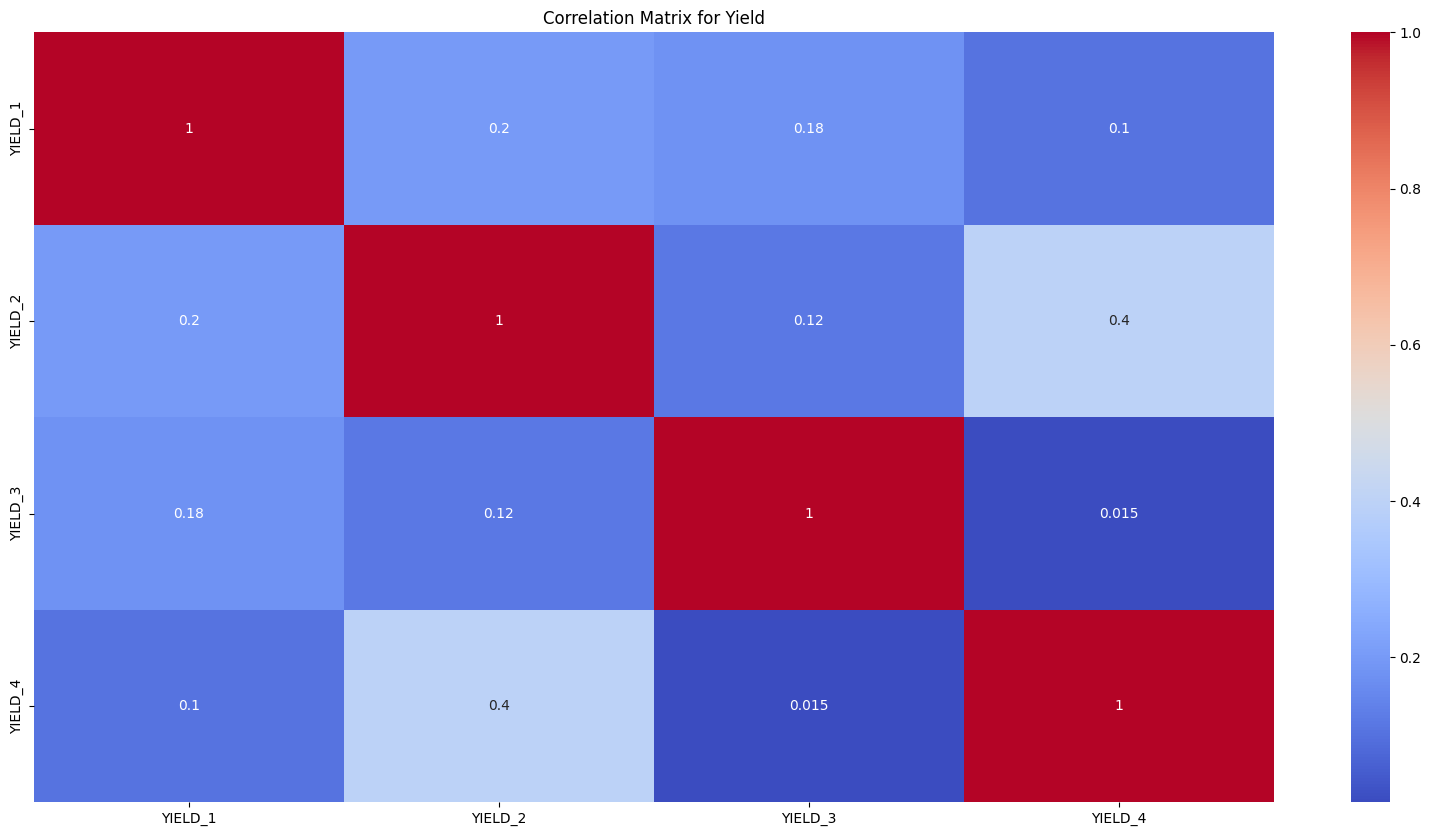

In [5]:
# correlation matrix
plt.figure(figsize=(20, 10))
corr_matrix = YIELD.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Yield')
plt.show()

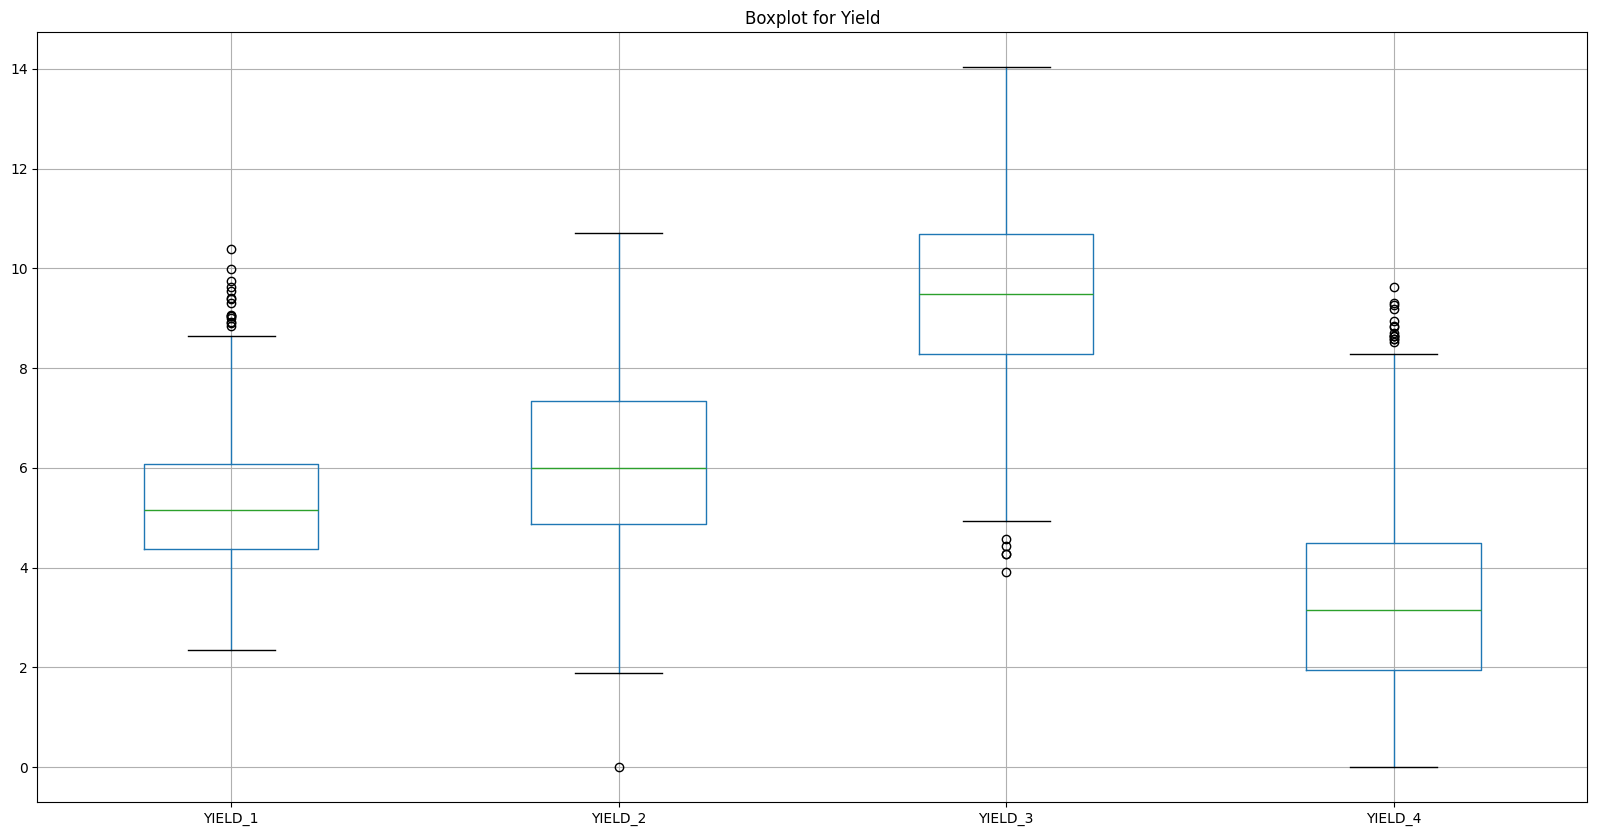

In [6]:
# boxplot
plt.figure(figsize=(20, 10))
YIELD.boxplot(grid=True)
plt.title('Boxplot for Yield')
plt.show()

We don't have strong corellation between Yield, variables are not totaly decorellated, <br>
There are some outliers but I have only 1000 data, so I won't remove these outliers at first

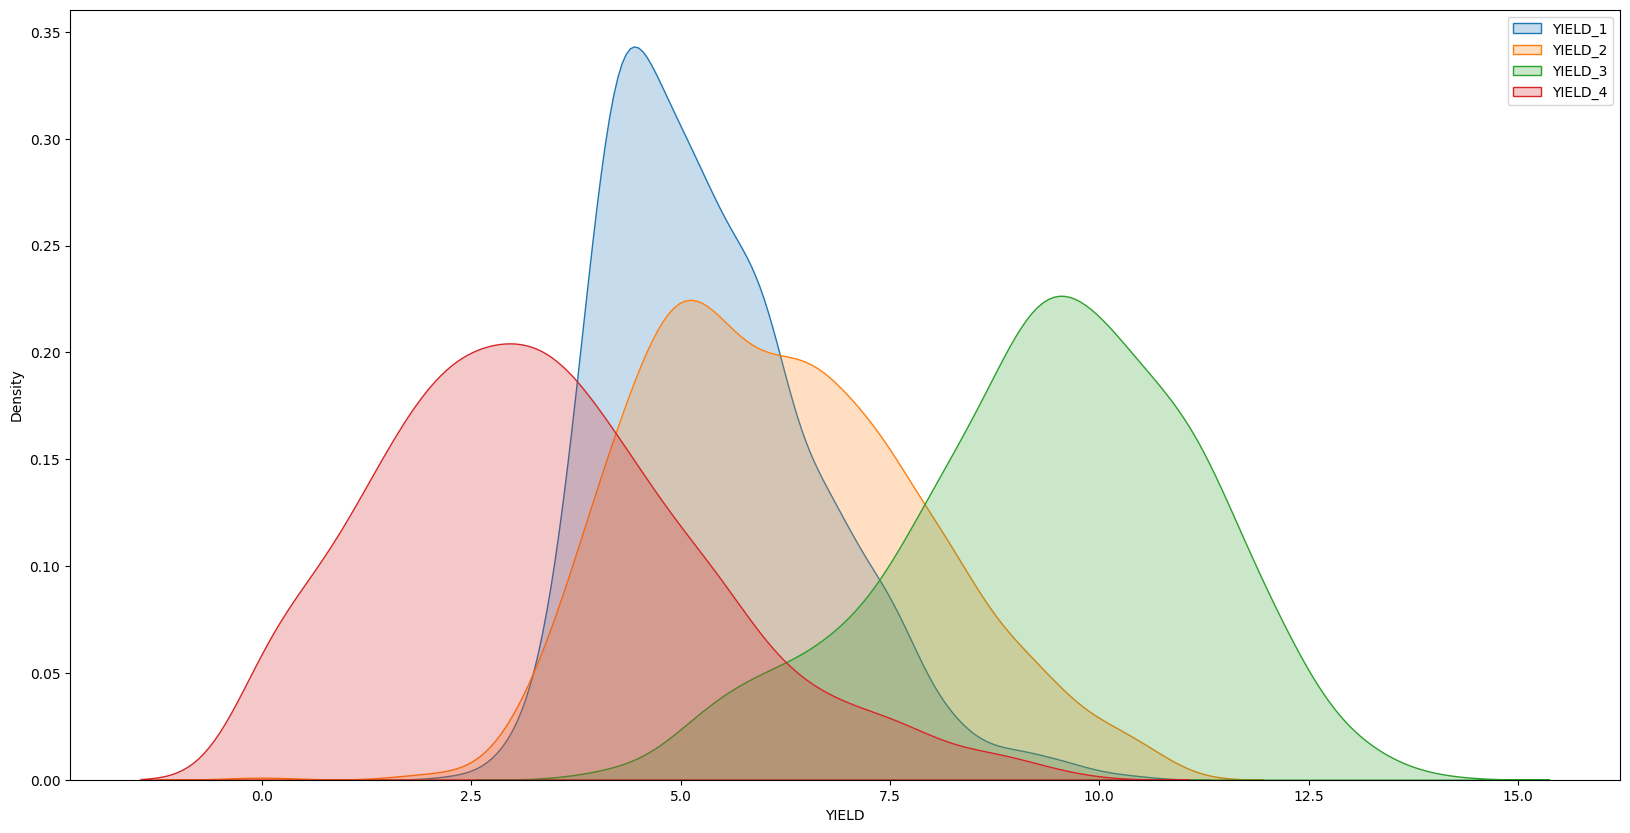

In [7]:
# plot distribution
plt.figure(figsize=(20, 10))
plot4dist(YIELD.values, 'YIELD')

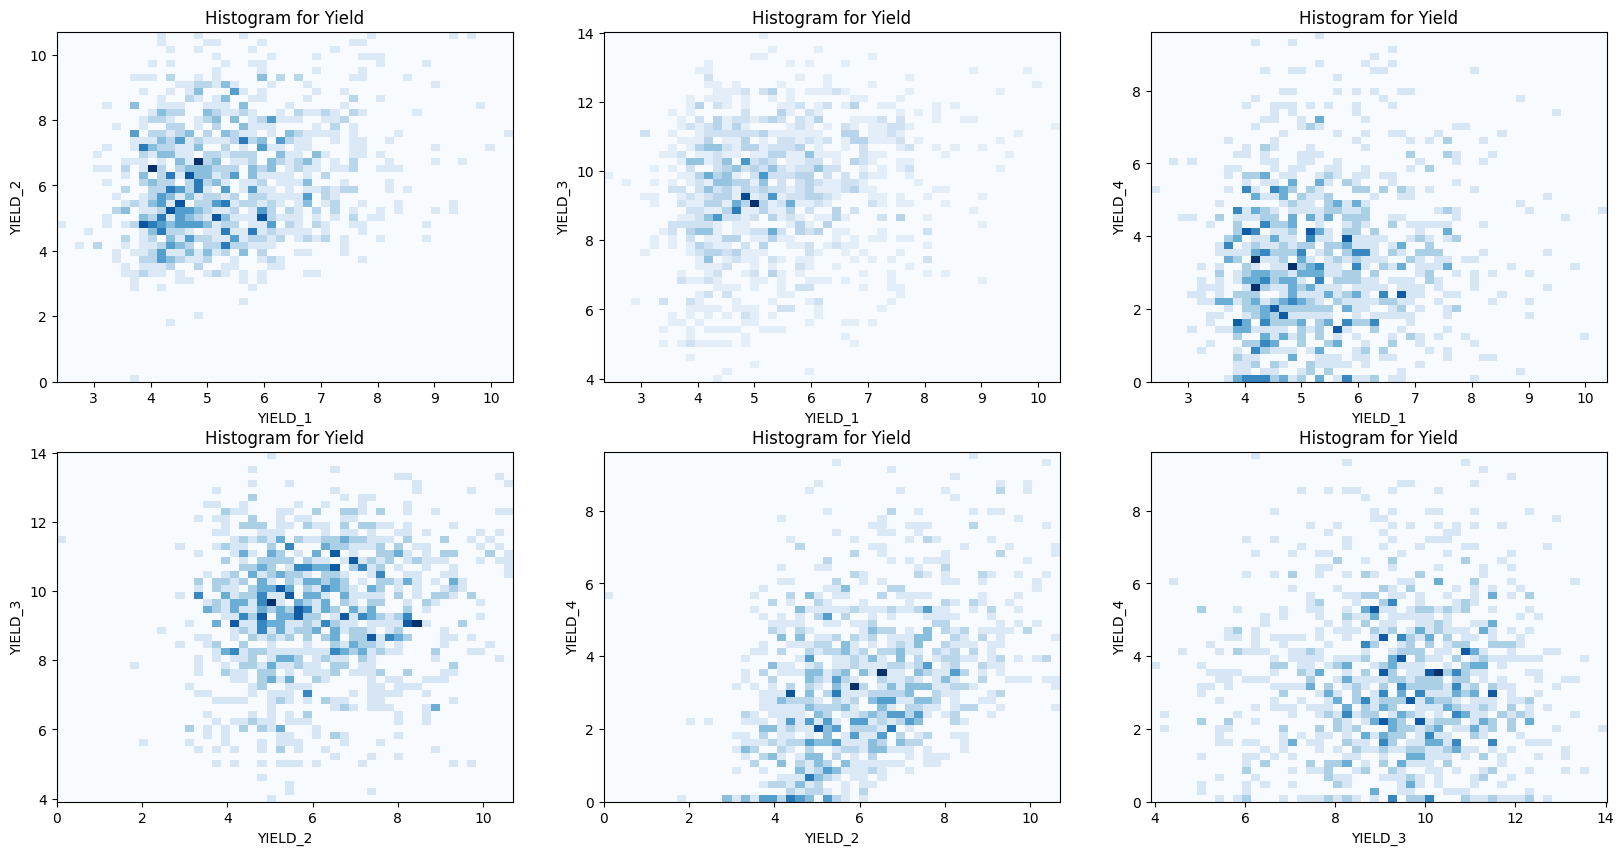

In [8]:
# 2D histogram
plt.figure(figsize=(20, 10))
c = 1
for i in range(1, 5):
    for j in range(i+1, 5):
        ax = plt.subplot(2, 3, c)
        c += 1
        plt.hist2d(YIELD['YIELD_'+str(i)], YIELD['YIELD_'+str(j)], bins=50, cmap='Blues')
        plt.xlabel('YIELD_'+str(i))
        plt.ylabel('YIELD_'+str(j))
        plt.title('Histogram for Yield')

Not such a hard distribution, our model doesn't need to be more complex

## 2. GAN model

* normalize the data

In [9]:
scaler = StandardScaler()
YIELD_scaled = scaler.fit_transform(YIELD)
print(YIELD_scaled.shape)

(1000, 4)


* parameters and train_dataset

In [10]:
# Parameters
latent_dim = 50
epochs = 5000
batch_size = 128
buffer_size = 100
noise = np.load('../data/noise.npy')

# batch and shuffling the data
train_dataset = tf.data.Dataset.from_tensor_slices(YIELD_scaled).shuffle(buffer_size).batch(batch_size)

* 2 architectures for generator and 3 for discrimator

In [11]:
# 2 architectures for generator
def build_generator_architecture_1(latent_dim): # best
    dtype = 'float64'
    model = tf.keras.Sequential(name='generator_1')
    model.add(layers.Dense(128, input_dim=latent_dim, activation='relu' ,dtype=dtype))
    model.add(layers.Dense(64, activation='relu', dtype=dtype))
    model.add(layers.Dense(32, activation='relu', dtype=dtype))
    model.add(layers.Dense(4, dtype=dtype,activation="linear"))  # (YIELD_1, YIELD_2, YIELD_3, YIELD_4)
    return model

def build_generator_architecture_2(latent_dim):
    dtype = 'float64'
    inputs = tf.keras.Input(shape=(latent_dim,), dtype=dtype)
    x = layers.Dense(256, activation='relu', dtype=dtype)(inputs)
    x = layers.BatchNormalization()(x)
    # Bloc ResNet
    y = layers.Dense(256, activation='relu', dtype=dtype)(x)
    y = layers.Dense(256, dtype=dtype)(y)
    x = layers.add([x, y])
    x = layers.Activation('relu', dtype=dtype)(x)
    # Fin du bloc ResNet
    x = layers.Dense(512, activation='relu', dtype=dtype)(x)
    x = layers.Dense(4, activation='tanh', dtype=dtype)(x)  # Dimension de sortie = 4
    model = tf.keras.Model(inputs=inputs, outputs=x, name='generator_2')
    return model

In [12]:
# 3 architectures for discriminator
def build_discriminator_architecture_1():
    dtype = 'float64'
    model = tf.keras.Sequential(name='discriminator_1')
    model.add(layers.Dense(128, input_dim=4, activation='relu', dtype=dtype))
    model.add(layers.Dense(64, activation='relu', dtype=dtype))
    model.add(layers.Dense(32, activation='relu', dtype=dtype))
    model.add(layers.Dense(1, activation='sigmoid', dtype=dtype))
    return model

def build_discriminator_architecture_2(): # best
    dtype = 'float64'
    model = tf.keras.Sequential(name='discriminator_2')
    model.add(layers.Dense(32, input_dim=4, activation='relu', dtype=dtype))
    model.add(layers.Dense(64, activation='relu', dtype=dtype))
    model.add(layers.Dense(128, activation='relu', dtype=dtype))
    model.add(layers.Dense(1, activation='sigmoid', dtype=dtype))
    return model

def build_discriminator_architecture_3():
    dtype = 'float64'
    model = tf.keras.Sequential(name='discriminator_3')
    model.add(layers.Dense(256, input_dim=4, activation='relu', dtype=dtype))
    model.add(layers.Dense(512, activation='relu', dtype=dtype))
    model.add(layers.Dense(1024, activation='relu', dtype=dtype))
    model.add(layers.Dense(1, activation='sigmoid', dtype=dtype))
    return model

* Loss function and Optimizers

In [13]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Optimizers
learning_rate = 1e-4
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate)

* GAN class

In [14]:
# GAN model
class GAN(Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.latent_dim = generator.input_shape[1]
        self.generator = generator
        self.discriminator = discriminator
        self.generator_name = generator.name
        self.discriminator_name = discriminator.name
        self.best_swd = float('inf')
        self.best_epoch = -1

    def call(self, inputs):
        return self.generator(inputs)

    def train_step(self, data):
        # data is a batch of real data
        # sample random points in the latent space
        batch_size = tf.shape(data)[0]
        print(batch_size)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # decode them to fake data
        generated_data = self.generator(random_latent_vectors)
        # combine them with real data
        combined_data = tf.concat([generated_data, data], axis=0)
        # assemble labels discriminating real from fake data
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data)
            d_loss = cross_entropy(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        # sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        # assemble labels that say "all real data"
        misleading_labels = tf.zeros((batch_size, 1))
        # train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            print(generated_data.shape)
            g_loss = cross_entropy(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {'d_loss': d_loss, 'g_loss': g_loss}

* Callbacks

In [15]:
# Callbacks to only show each 100th epochs, early stopping and reduce learning rate on plateau
class GANMonitor(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 200 == 0:
            print('Epoch {} of {}'.format(epoch, epochs))
            print('discriminator loss: ', logs['d_loss'])
            print('generator loss: ', logs['g_loss'])
            print()

# Callbacks to save best model after each 100th epoch
class save_best_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 100 == 0:
            generated_data = self.model.generator(tf.random.normal(shape=(10000, self.model.latent_dim)))
            generated_data = scaler.inverse_transform(generated_data)
            swd = ot.sliced_wasserstein_distance(YIELD.values, generated_data)
            if swd < self.model.best_swd:
                self.model.best_swd = swd
                self.model.best_epoch = epoch
                print('best epoch: ', epoch)
                print('best swd: ', swd)
                self.model.generator.save('models/'+self.model.generator_name+ '_with_' + self.model.discriminator_name + '.h5')
                self.model.discriminator.save('models/'+self.model.discriminator_name+ '_with_' + self.model.generator_name + '.h5')
                print()

* Class to build and train the model, compute swd, plot distribution

In [16]:
class RunGAN():
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        self.gan = GAN(self.generator, self.discriminator)
        self.gan.compile(generator_optimizer, discriminator_optimizer, cross_entropy)

    def run(self):
        self.gan.fit(train_dataset, epochs=epochs, callbacks=[GANMonitor(), save_best_model()], verbose=0)
    
    def update_generator_params(self):
        # load best parameters
        self.generator = tf.keras.models.load_model('models/'+self.generator.name+ '_with_' + self.discriminator.name + '.h5')
        print('generator parameters updated')
        print()
    
    def get_swd_on_noise(self, noise):
        generated_data = self.generator(noise, training=False)
        generated_data = scaler.inverse_transform(generated_data)
        swd = ot.sliced_wasserstein_distance(YIELD.values, generated_data)
        return swd
    
    def print_swd_on_noise(self, noise):
        swd = self.get_swd_on_noise(noise)
        print('SWD: ', swd)
        print('empiral bayes error: ', b_error)
        print('SWD/empiral bayes error: ', swd/b_error)
        print()
    
    def check_robutness(self, N=100):
        swds = []
        for i in range(N):
            # generate data
            generated_data = self.generator(tf.random.normal(shape=(10000, latent_dim)))
            generated_data = scaler.inverse_transform(generated_data)
            # calculate SWD
            swd = ot.sliced_wasserstein_distance(YIELD.values, generated_data)
            swds.append(swd)
        print('mean of SWD: ', np.mean(swds))
        print('mean of SWD/empiral bayes error: ', np.mean(swds)/b_error)
        print()
    
    def plot_distribution(self, noise):
        generated_data = self.generator(noise, training=False)
        generated_data = scaler.inverse_transform(generated_data)
        plt.figure(figsize=(20, 10))
        plt.subplot(121)
        plot4dist(YIELD.values, 'YIELD')
        plt.subplot(122)
        plot4dist(generated_data, 'generated YIELD')
        plt.show()
    
    def oneshot(self, noise):
        # load best parameters
        print('#################### load best parameters ####################')
        self.update_generator_params()

        # generate data from the given noise
        print('#################### generate data from the given noise ####################')
        self.print_swd_on_noise(noise)

        # robustness test
        print('#################### robustness test ####################')
        N = 100
        self.check_robutness(N)

        # plot the distribution of true data and generated data
        print('#################### plot the distribution of true data and generated data ####################')
        self.plot_distribution(noise)

## 2.a Generator_1 + Discriminator_1

In [17]:
# Build an instance of the GAN
gan_model_11 = RunGAN(build_generator_architecture_1(latent_dim), build_discriminator_architecture_1())
gan_model_11.run()

Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)
Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0 of 5000
discriminator loss:  0.6781444650930392
generator loss:  0.6525860718634582

best epoch:  0
best swd:  1.3412499934705426


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 200 of 5000
discriminator loss:  0.6001513795061512
generator loss:  0.8275637747220252

best epoch:  200
best swd:  1.1619840544392723


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



best epoch:  300
best swd:  1.1085801079857898



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 400 of 5000
discriminator loss:  0.626841590867622
generator loss:  0.863798046845506

best epoch:  400
best swd:  0.9610066993607516



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epoch:  500
best swd:  0.7821971889555567



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 600 of 5000
discriminator loss:  0.7631172019731592
generator loss:  0.6598207677736287

Epoch 800 of 5000
discriminator loss:  0.6300585685544492
generator loss:  0.8099423358579094

best epoch:  900
best swd:  0.6010722654873103



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1000 of 5000
discriminator loss:  0.7302290786022559
generator loss:  0.861836707711891

best epoch:  1100
best swd:  0.5656856367334356



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1200 of 5000
discriminator loss:  0.6822182975905892
generator loss:  0.6647589735302757

Epoch 1400 of 5000
discriminator loss:  0.760182148504734
generator loss:  0.6720299107636301

Epoch 1600 of 5000
discriminator loss:  0.7008781678595837
generator loss:  0.7644850280804245

Epoch 1800 of 5000
discriminator loss:  0.7187370871738193
generator loss:  0.675575422664755

Epoch 2000 of 5000
discriminator loss:  0.7289141906985552
generator loss:  0.7400033760030639

Epoch 2200 of 5000
discriminator loss:  0.6786774822120122
generator loss:  0.806931722440451

Epoch 2400 of 5000
discriminator loss:  0.6991195919750522
generator loss:  0.7344868353837583

best epoch:  2500
best swd:  0.4091744597092793



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2600 of 5000
discriminator loss:  0.7475613742702727
generator loss:  0.6762083555983233

best epoch:  2700
best swd:  0.342078006091061



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2800 of 5000
discriminator loss:  0.6785037865611987
generator loss:  0.7828165730146904

Epoch 3000 of 5000
discriminator loss:  0.6856065425814137
generator loss:  0.8185513155845648

Epoch 3200 of 5000
discriminator loss:  0.6785492820928098
generator loss:  0.7722430859072489

Epoch 3400 of 5000
discriminator loss:  0.6899381913207981
generator loss:  0.7614007998607858

Epoch 3600 of 5000
discriminator loss:  0.7231464126999346
generator loss:  0.6822661714912927

Epoch 3800 of 5000
discriminator loss:  0.6798914627802477
generator loss:  0.81231898569301

Epoch 4000 of 5000
discriminator loss:  0.6863624338286143
generator loss:  0.8074716957404582

Epoch 4200 of 5000
discriminator loss:  0.6892366050093628
generator loss:  0.8076493560129111

Epoch 4400 of 5000
discriminator loss:  0.7044978472741518
generator loss:  0.7617582311630477

Epoch 4600 of 5000
discriminator loss:  0.692490365839806
generator loss:  0.7340524997009955

Epoch 4800 of 5000
discriminator loss:  0.6

#################### load best parameters ####################


generator parameters updated

#################### generate data from the given noise ####################
SWD:  0.3765485148262625
empiral bayes error:  0.1228587905124484
SWD/empiral bayes error:  3.0648886681666423

#################### robustness test ####################
mean of SWD:  0.34955820418665773
mean of SWD/empiral bayes error:  2.8452030394295598

#################### plot the distribution of true data and generated data ####################


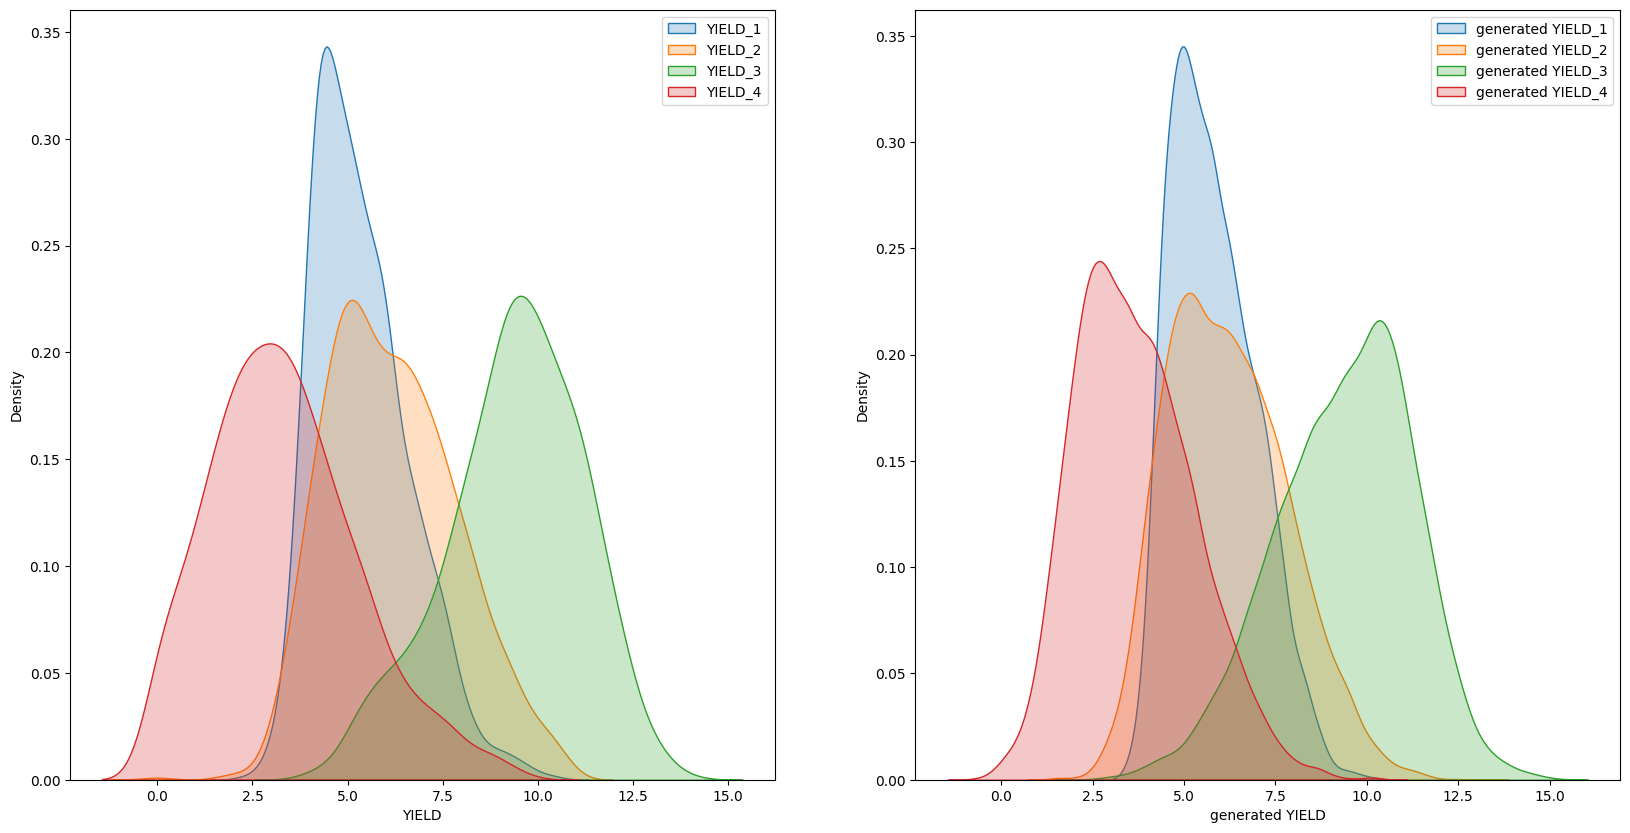

In [18]:
gan_model_11.oneshot(noise)

## 2.b Generator_1 + Discriminator_2

In [19]:
# Build an instance of the GAN
gan_model_12 = RunGAN(build_generator_architecture_1(latent_dim), build_discriminator_architecture_2())
gan_model_12.run()

Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)
Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0 of 5000
discriminator loss:  0.6798403347823017
generator loss:  0.6451186617201898

best epoch:  0
best swd:  1.3038457294232457



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200 of 5000
discriminator loss:  0.4511686393082257
generator loss:  1.0048898239970443

Epoch 400 of 5000
discriminator loss:  0.6579922040213978
generator loss:  1.1107713675443789

Epoch 600 of 5000
discriminator loss:  0.6221378618614948
generator loss:  0.8786559510197802

best epoch:  600
best swd:  1.099736302502691



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 800 of 5000
discriminator loss:  0.5777617620266828
generator loss:  1.1298843105620457

best epoch:  900
best swd:  0.8436950427738606



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1000 of 5000
discriminator loss:  0.6297048957095636
generator loss:  0.7232709585956223

best epoch:  1000
best swd:  0.7367853665356758



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1200 of 5000
discriminator loss:  0.7526659806687578
generator loss:  0.847165946860468

Epoch 1400 of 5000
discriminator loss:  0.5943187652535916
generator loss:  0.9823928438901858

Epoch 1600 of 5000
discriminator loss:  0.7085898882996436
generator loss:  0.7772039877388585

Epoch 1800 of 5000
discriminator loss:  0.6298672175136725
generator loss:  0.8126675644571453

best epoch:  1800
best swd:  0.6378456499368118



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epoch:  1900
best swd:  0.6024870663695883



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2000 of 5000
discriminator loss:  0.6269851782882416
generator loss:  0.7691705400844394

Epoch 2200 of 5000
discriminator loss:  0.6986340543463859
generator loss:  0.7441243727280041

Epoch 2400 of 5000
discriminator loss:  0.6494726105394226
generator loss:  0.804200037084171

Epoch 2600 of 5000
discriminator loss:  0.6851027414609102
generator loss:  0.7556053766896351

Epoch 2800 of 5000
discriminator loss:  0.70444392561492
generator loss:  0.8889617297106118

best epoch:  2800
best swd:  0.47645638727433537



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3000 of 5000
discriminator loss:  0.6961979988507057
generator loss:  0.7645442392164082

Epoch 3200 of 5000
discriminator loss:  0.7412816949242912
generator loss:  0.9486219699471301

Epoch 3400 of 5000
discriminator loss:  0.6155945828229356
generator loss:  0.7896035724998494

Epoch 3600 of 5000
discriminator loss:  0.6554081820768081
generator loss:  0.7868680824649099

Epoch 3800 of 5000
discriminator loss:  0.6916953856419579
generator loss:  0.7546837076058224

best epoch:  3800
best swd:  0.39714996513503875



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4000 of 5000
discriminator loss:  0.7029373358331739
generator loss:  0.8293814698979453

Epoch 4200 of 5000
discriminator loss:  0.6944415636073776
generator loss:  0.7192704364002689

Epoch 4400 of 5000
discriminator loss:  0.6887189372129202
generator loss:  0.7578694091624729

Epoch 4600 of 5000
discriminator loss:  0.6948703715454214
generator loss:  0.7198258206246627

Epoch 4800 of 5000
discriminator loss:  0.7084319012691039
generator loss:  0.7161478086381265



#################### load best parameters ####################


generator parameters updated

#################### generate data from the given noise ####################
SWD:  0.42312322996549556
empiral bayes error:  0.1228587905124484
SWD/empiral bayes error:  3.4439801026905235

#################### robustness test ####################
mean of SWD:  0.4160403615686185
mean of SWD/empiral bayes error:  3.386329621456465

#################### plot the distribution of true data and generated data ####################


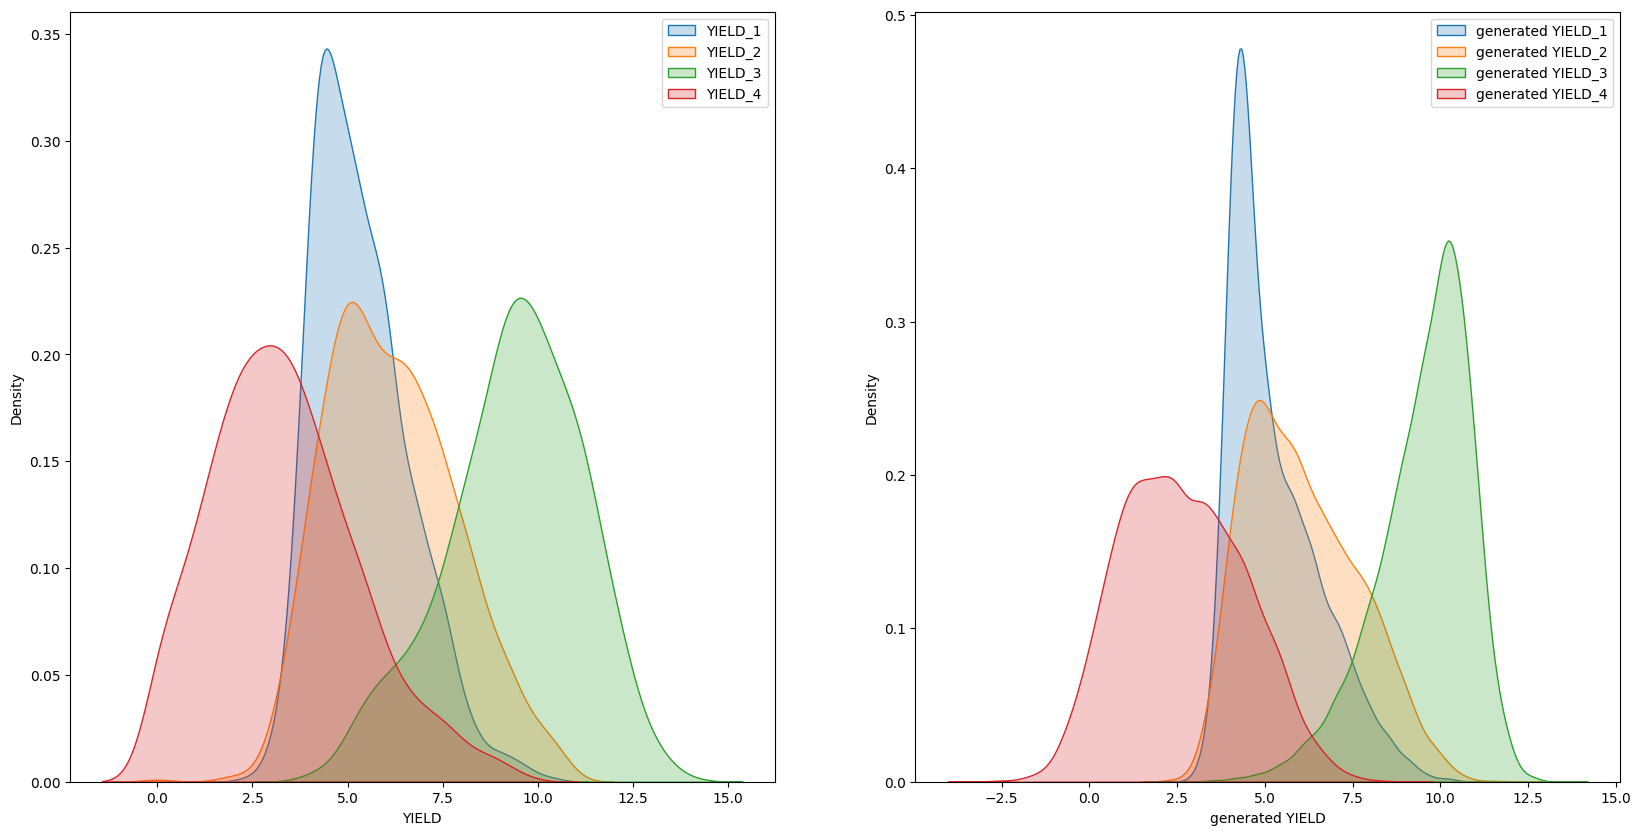

In [20]:
gan_model_12.oneshot(noise)

## 2.c Generator_1 + Discriminator_3

In [21]:
# Build an instance of the GAN
gan_model_13 = RunGAN(build_generator_architecture_1(latent_dim), build_discriminator_architecture_3())
gan_model_13.run()

Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)
Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch 0 of 5000
discriminator loss:  0.5646105549585325
generator loss:  0.6065241641121538

best epoch:  0
best swd:  1.2547529269242415



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epoch:  100
best swd:  0.2580886603169108



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200 of 5000
discriminator loss:  0.6454808324511774
generator loss:  0.8605023446792811

Epoch 400 of 5000
discriminator loss:  0.7129470025338307
generator loss:  0.7235287561613638

best epoch:  500
best swd:  0.23097022814307305



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 600 of 5000
discriminator loss:  0.651073306210229
generator loss:  0.8816724420119998

best epoch:  700
best swd:  0.09813187723203178



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 800 of 5000
discriminator loss:  0.6083416482547547
generator loss:  0.9195637412904178

Epoch 1000 of 5000
discriminator loss:  0.49743007581902204
generator loss:  1.1749746768136131

Epoch 1200 of 5000
discriminator loss:  0.42063056672381083
generator loss:  1.5277746759170416

Epoch 1400 of 5000
discriminator loss:  0.31881007099820935
generator loss:  1.9358095151678327

Epoch 1600 of 5000
discriminator loss:  0.30772135765346265
generator loss:  2.4123690869696555

Epoch 1800 of 5000
discriminator loss:  0.2121713071989826
generator loss:  2.810504530250844

Epoch 2000 of 5000
discriminator loss:  0.16771357586573715
generator loss:  3.563076361156221

Epoch 2200 of 5000
discriminator loss:  0.1308923916260802
generator loss:  3.95668098406679

Epoch 2400 of 5000
discriminator loss:  0.11559292322689513
generator loss:  4.549410719504021

Epoch 2600 of 5000
discriminator loss:  0.10084065202257711
generator loss:  4.910611180662604

Epoch 2800 of 5000
discriminator loss:  

#################### load best parameters ####################
generator parameters updated

#################### generate data from the given noise ####################
SWD:  0.10661383660166317
empiral bayes error:  0.1228587905124484
SWD/empiral bayes error:  0.8677754042423261

#################### robustness test ####################
mean of SWD:  0.1065450204372237
mean of SWD/empiral bayes error:  0.8672152801832138

#################### plot the distribution of true data and generated data ####################


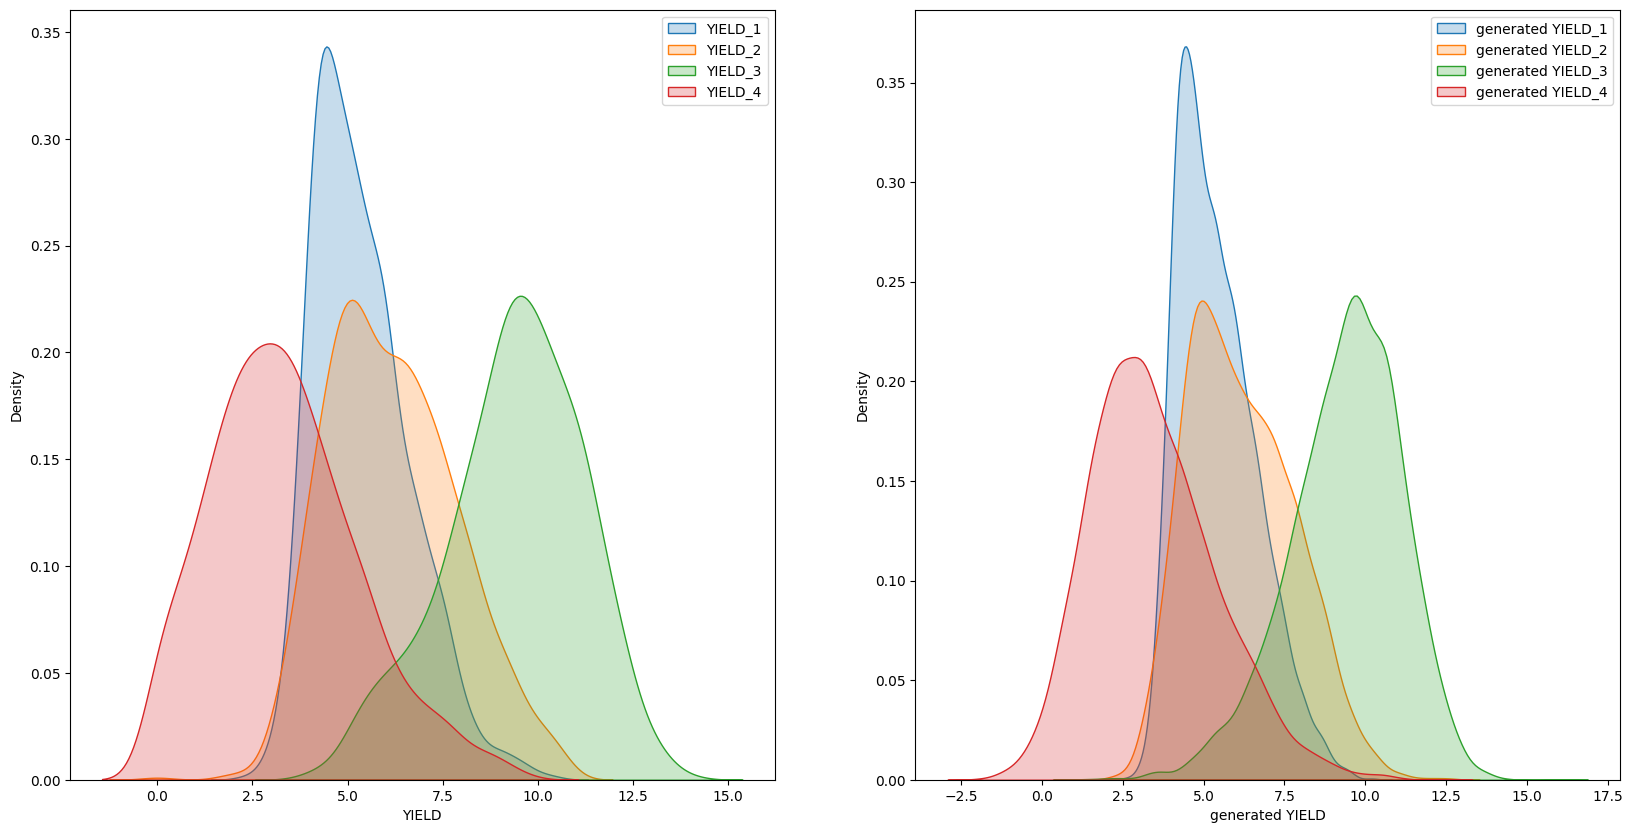

In [22]:
gan_model_13.oneshot(noise)

## 2.e Generator_2 + Discriminator_1

In [23]:
# Build an instance of the GAN
gan_model_21 = RunGAN(build_generator_architecture_2(latent_dim), build_discriminator_architecture_1())
gan_model_21.run()

Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)
Tensor("strided_slice:0", shape=(), dtype=int32)


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


(None, 4)
Epoch 0 of 5000
discriminator loss:  0.6496450973195732
generator loss:  0.638301464728539

best epoch:  0
best swd:  2.2910098478577026



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200 of 5000
discriminator loss:  0.7571766745067942
generator loss:  0.6458709285738594

best epoch:  200
best swd:  2.017122366328117



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 400 of 5000
discriminator loss:  0.7008273385619196
generator loss:  0.8144163355174843

Epoch 600 of 5000
discriminator loss:  1.2657328516504125
generator loss:  0.3784558020366713

best epoch:  700
best swd:  1.8725813859864395



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 800 of 5000
discriminator loss:  0.46837585819664784
generator loss:  1.320990235168148

Epoch 1000 of 5000
discriminator loss:  0.3673337014739148
generator loss:  1.7160121850663368

Epoch 1200 of 5000
discriminator loss:  0.37366940189254605
generator loss:  2.015233869271032

Epoch 1400 of 5000
discriminator loss:  0.7787282246109288
generator loss:  0.7661532672552467

Epoch 1600 of 5000
discriminator loss:  0.08740536730346869
generator loss:  3.5954858283378317

best epoch:  1700
best swd:  1.7172069338237497



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1800 of 5000
discriminator loss:  0.23998879656729988
generator loss:  1.8093589354885375

Epoch 2000 of 5000
discriminator loss:  0.31180622900149585
generator loss:  2.236508992525711

best epoch:  2100
best swd:  1.5121544582577064



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2200 of 5000
discriminator loss:  0.45656095758354004
generator loss:  1.254678625769795

best epoch:  2200
best swd:  1.4601499426828526



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epoch:  2300
best swd:  1.338085474001813



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2400 of 5000
discriminator loss:  0.3350563186275549
generator loss:  2.241963984155732

Epoch 2600 of 5000
discriminator loss:  0.8700810262909194
generator loss:  1.3326996286306465

Epoch 2800 of 5000
discriminator loss:  0.05398581707281521
generator loss:  4.929480339427917

Epoch 3000 of 5000
discriminator loss:  0.1965280562962214
generator loss:  2.4912781684247522

Epoch 3200 of 5000
discriminator loss:  0.08095929378793423
generator loss:  4.296893604320173

Epoch 3400 of 5000
discriminator loss:  0.5789586108365635
generator loss:  0.7582437104069549

Epoch 3600 of 5000
discriminator loss:  0.08484678243153408
generator loss:  4.285438695142451

Epoch 3800 of 5000
discriminator loss:  0.39525578806853745
generator loss:  1.076466666338665

Epoch 4000 of 5000
discriminator loss:  0.30452561442759357
generator loss:  1.8616634608463447

best epoch:  4000
best swd:  1.2563086204064644



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4200 of 5000
discriminator loss:  0.024048975878828874
generator loss:  5.387548964873673

best epoch:  4300
best swd:  1.1077409240982514



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4400 of 5000
discriminator loss:  0.1114440963768369
generator loss:  3.781222055824791

Epoch 4600 of 5000
discriminator loss:  0.5180003869808097
generator loss:  1.7381265957333591

Epoch 4800 of 5000
discriminator loss:  0.7638984844828272
generator loss:  1.6346721414589036



#################### load best parameters ####################


generator parameters updated

#################### generate data from the given noise ####################
SWD:  1.2902870515507217
empiral bayes error:  0.1228587905124484
SWD/empiral bayes error:  10.50219561961247

#################### robustness test ####################
mean of SWD:  1.1743557447526483
mean of SWD/empiral bayes error:  9.55858135876455

#################### plot the distribution of true data and generated data ####################


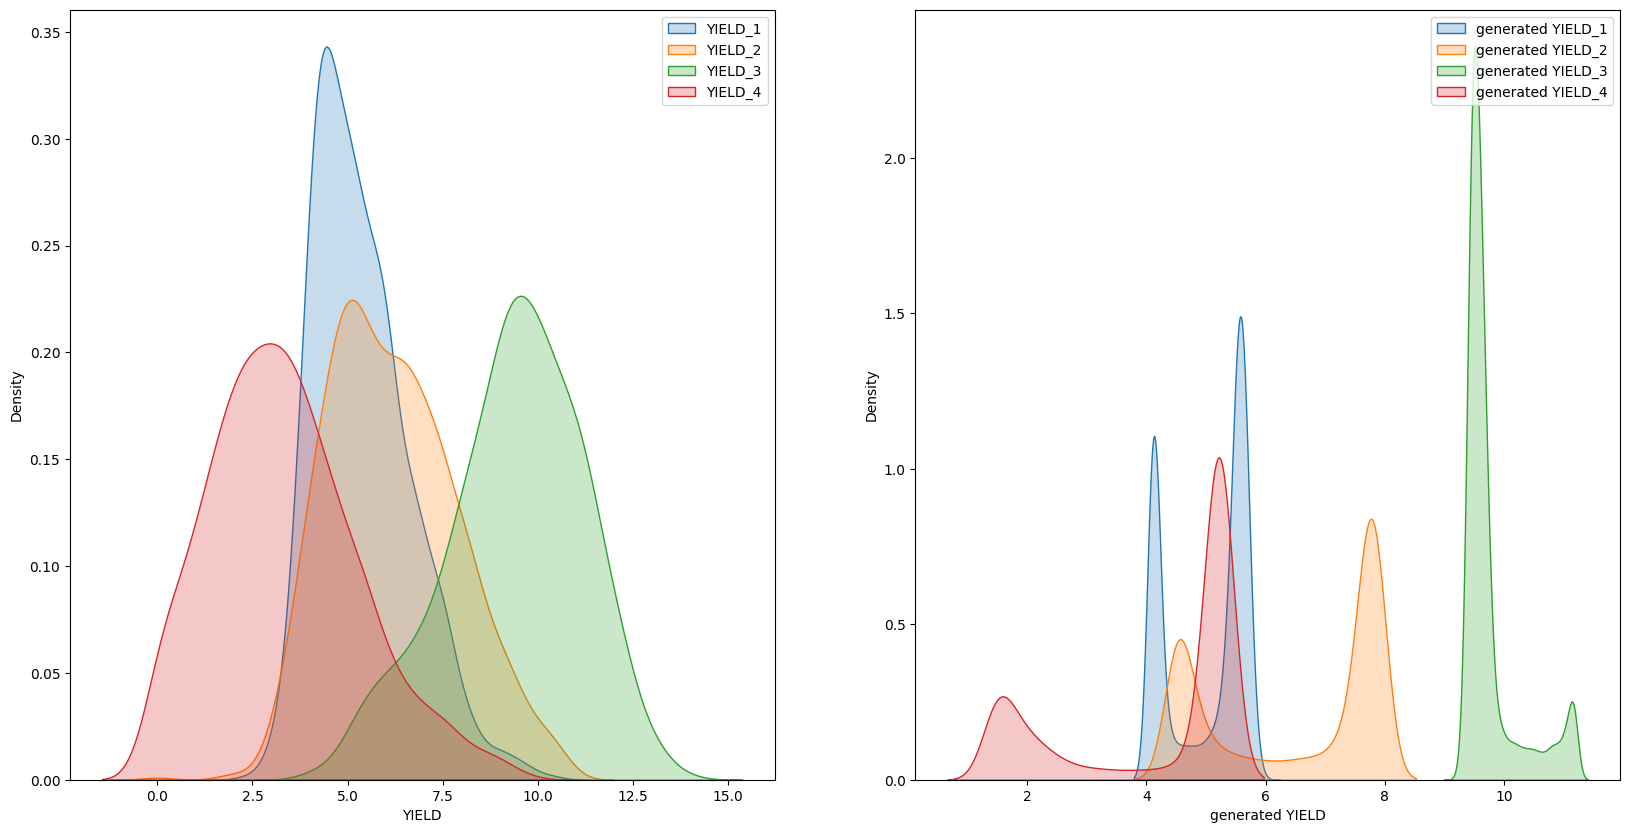

In [24]:
gan_model_21.oneshot(noise)

## 2.f Generator_2 + Discriminator_2

In [25]:
# Build an instance of the GAN
gan_model_22 = RunGAN(build_generator_architecture_2(latent_dim), build_discriminator_architecture_2())
gan_model_22.run()

Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)
Tensor("strided_slice:0", shape=(), dtype=int32)


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


(None, 4)
Epoch 0 of 5000
discriminator loss:  0.6591266088323116
generator loss:  0.6713004722745182

best epoch:  0
best swd:  2.318953574526326



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200 of 5000
discriminator loss:  -0.041128536261235964
generator loss:  12.86974602238838

best epoch:  200
best swd:  2.281362967325991



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 400 of 5000
discriminator loss:  -1.1851577137912945
generator loss:  131.97173067853788

Epoch 600 of 5000
discriminator loss:  0.40172991814800724
generator loss:  1.7608929809008136

best epoch:  700
best swd:  2.185960708158632



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 800 of 5000
discriminator loss:  0.9791091282252606
generator loss:  0.7060819034649467

best epoch:  800
best swd:  1.6381628309787648



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1000 of 5000
discriminator loss:  0.2833588146306459
generator loss:  2.2253445472191777

Epoch 1200 of 5000
discriminator loss:  0.1801303467884335
generator loss:  2.472951869776661

Epoch 1400 of 5000
discriminator loss:  0.40233380836695554
generator loss:  1.3002736112308217

Epoch 1600 of 5000
discriminator loss:  0.21861301602684755
generator loss:  2.244804682763847

Epoch 1800 of 5000
discriminator loss:  0.8112939282875197
generator loss:  3.207856786676721

Epoch 2000 of 5000
discriminator loss:  0.1552525086708192
generator loss:  2.5845976830400663

Epoch 2200 of 5000
discriminator loss:  0.2585275741939728
generator loss:  2.1776775247858455

best epoch:  2200
best swd:  1.6049226615175252



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2400 of 5000
discriminator loss:  0.2030786219310437
generator loss:  2.8658838972598244

best epoch:  2500
best swd:  1.2606643507590496



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2600 of 5000
discriminator loss:  0.3934629424155978
generator loss:  1.6963830687868333

Epoch 2800 of 5000
discriminator loss:  0.191890974366714
generator loss:  2.309800921174968

best epoch:  2900
best swd:  1.188497442797731



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3000 of 5000
discriminator loss:  0.32083642752187447
generator loss:  1.8716884217795786

Epoch 3200 of 5000
discriminator loss:  0.423406331721016
generator loss:  1.9049191783186532

Epoch 3400 of 5000
discriminator loss:  0.30606950994078763
generator loss:  1.8904139288945743

Epoch 3600 of 5000
discriminator loss:  0.14727553717773256
generator loss:  2.4987772388772855

Epoch 3800 of 5000
discriminator loss:  0.10159049410241897
generator loss:  4.122026080979754

best epoch:  3900
best swd:  0.9865989707225861



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4000 of 5000
discriminator loss:  0.40354001138792406
generator loss:  1.8009839941649703

Epoch 4200 of 5000
discriminator loss:  0.3922189809873557
generator loss:  1.6229673171067434

Epoch 4400 of 5000
discriminator loss:  0.16661629726426092
generator loss:  2.4966397711492836

Epoch 4600 of 5000
discriminator loss:  0.11153067324637565
generator loss:  3.276694967350756

Epoch 4800 of 5000
discriminator loss:  0.31708923902011205
generator loss:  1.6425067524712726



#################### load best parameters ####################
generator parameters updated

#################### generate data from the given noise ####################
SWD:  0.96425015026458
empiral bayes error:  0.1228587905124484
SWD/empiral bayes error:  7.848442478089344

#################### robustness test ####################
mean of SWD:  0.9817139589610008
mean of SWD/empiral bayes error:  7.990587851843867

#################### plot the distribution of true data and generated data ####################


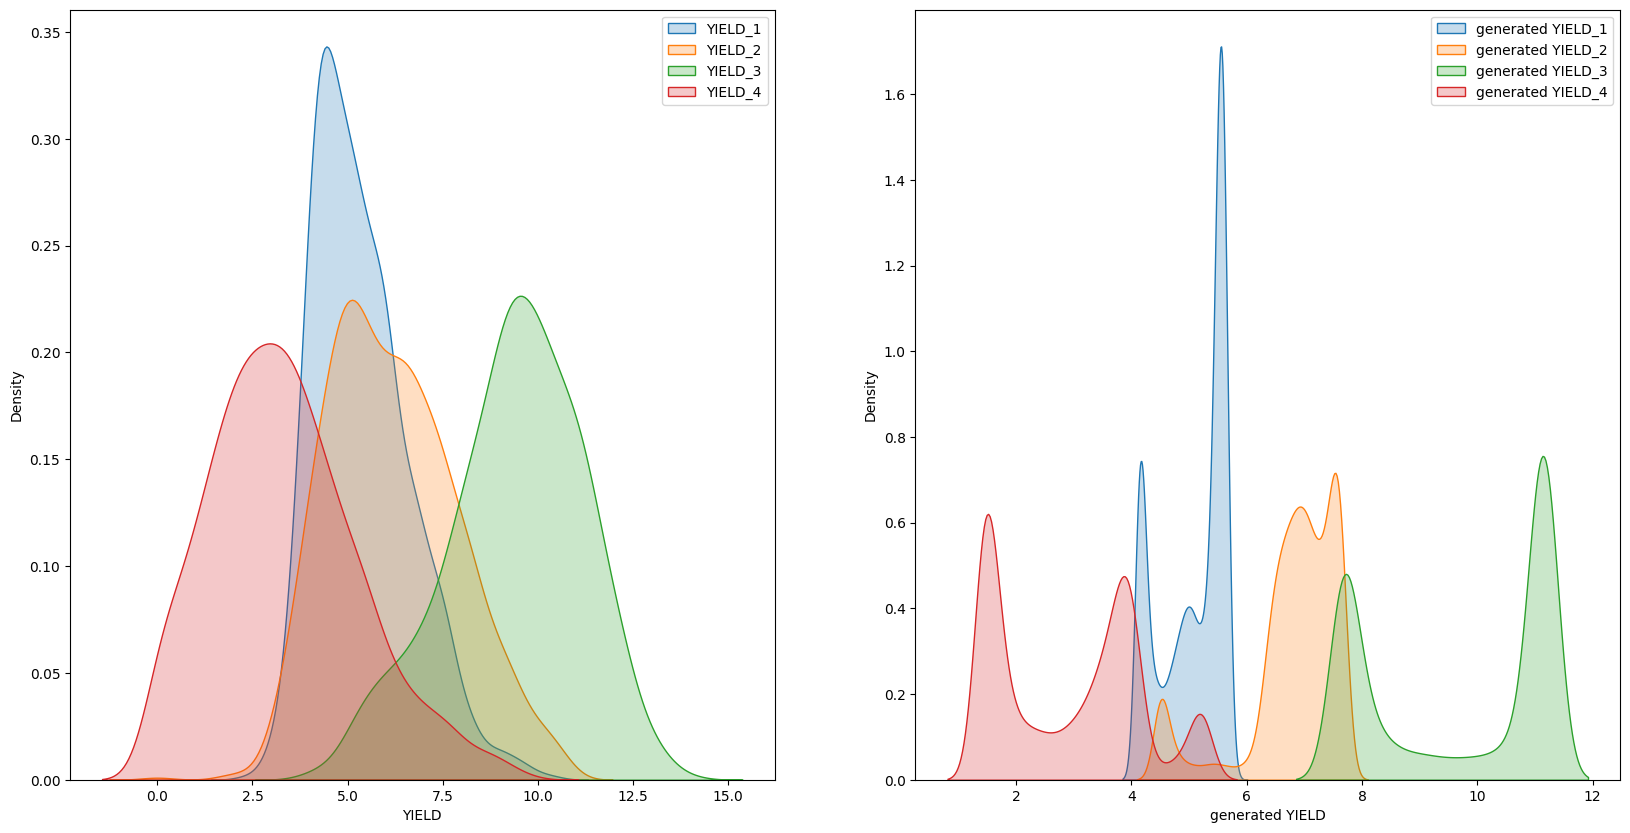

In [26]:
gan_model_22.oneshot(noise)

## 2.g Generator_2 + Discriminator_3

In [27]:
# Build an instance of the GAN
gan_model_23 = RunGAN(build_generator_architecture_2(latent_dim), build_discriminator_architecture_3())
gan_model_23.run()

Tensor("strided_slice:0", shape=(), dtype=int32)
(None, 4)
Tensor("strided_slice:0", shape=(), dtype=int32)


/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


(None, 4)
Epoch 0 of 5000
discriminator loss:  0.7233681049386343
generator loss:  0.5383764068960244

best epoch:  0
best swd:  2.4872031431192108



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epoch:  100
best swd:  2.338013786316673



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 200 of 5000
discriminator loss:  -3.7164231752827943
generator loss:  413.7626809014862

Epoch 400 of 5000
discriminator loss:  -0.6838881950888454
generator loss:  82.83276975980294

best epoch:  500
best swd:  2.146531906590086



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 600 of 5000
discriminator loss:  0.8099565452195988
generator loss:  3.1318886363161247

best epoch:  600
best swd:  1.64997280708047



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 800 of 5000
discriminator loss:  0.2646578632104268
generator loss:  3.5668511214084173

best epoch:  900
best swd:  1.1368972311811933



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1000 of 5000
discriminator loss:  0.4204094512477988
generator loss:  2.6143075679453203

best epoch:  1000
best swd:  0.723599157273116



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


best epoch:  1100
best swd:  0.6409474533486573



/Users/dabereabasse/Desktop/GenHack3/Copy/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1200 of 5000
discriminator loss:  0.3843501413535269
generator loss:  2.2925660617860664

Epoch 1400 of 5000
discriminator loss:  0.34663407448524564
generator loss:  2.8504104567259585

Epoch 1600 of 5000
discriminator loss:  0.3188103250896986
generator loss:  2.429838949341285

Epoch 1800 of 5000
discriminator loss:  0.23683367626113688
generator loss:  1.950721099812204

Epoch 2000 of 5000
discriminator loss:  0.2947069468551691
generator loss:  2.076742524836276

Epoch 2200 of 5000
discriminator loss:  0.32279531581103516
generator loss:  2.2743629633642577

Epoch 2400 of 5000
discriminator loss:  0.2823931669952022
generator loss:  2.170015461962794

Epoch 2600 of 5000
discriminator loss:  0.2657988418695592
generator loss:  2.102312653882669

Epoch 2800 of 5000
discriminator loss:  0.24743151621688458
generator loss:  2.748126614471612

Epoch 3000 of 5000
discriminator loss:  0.2548598329783737
generator loss:  2.4223063054167735

Epoch 3200 of 5000
discriminator loss:  0.

#################### load best parameters ####################
generator parameters updated

#################### generate data from the given noise ####################
SWD:  0.585984061956761
empiral bayes error:  0.1228587905124484
SWD/empiral bayes error:  4.769573748142893

#################### robustness test ####################
mean of SWD:  0.6131719101343733
mean of SWD/empiral bayes error:  4.9908672189984244

#################### plot the distribution of true data and generated data ####################


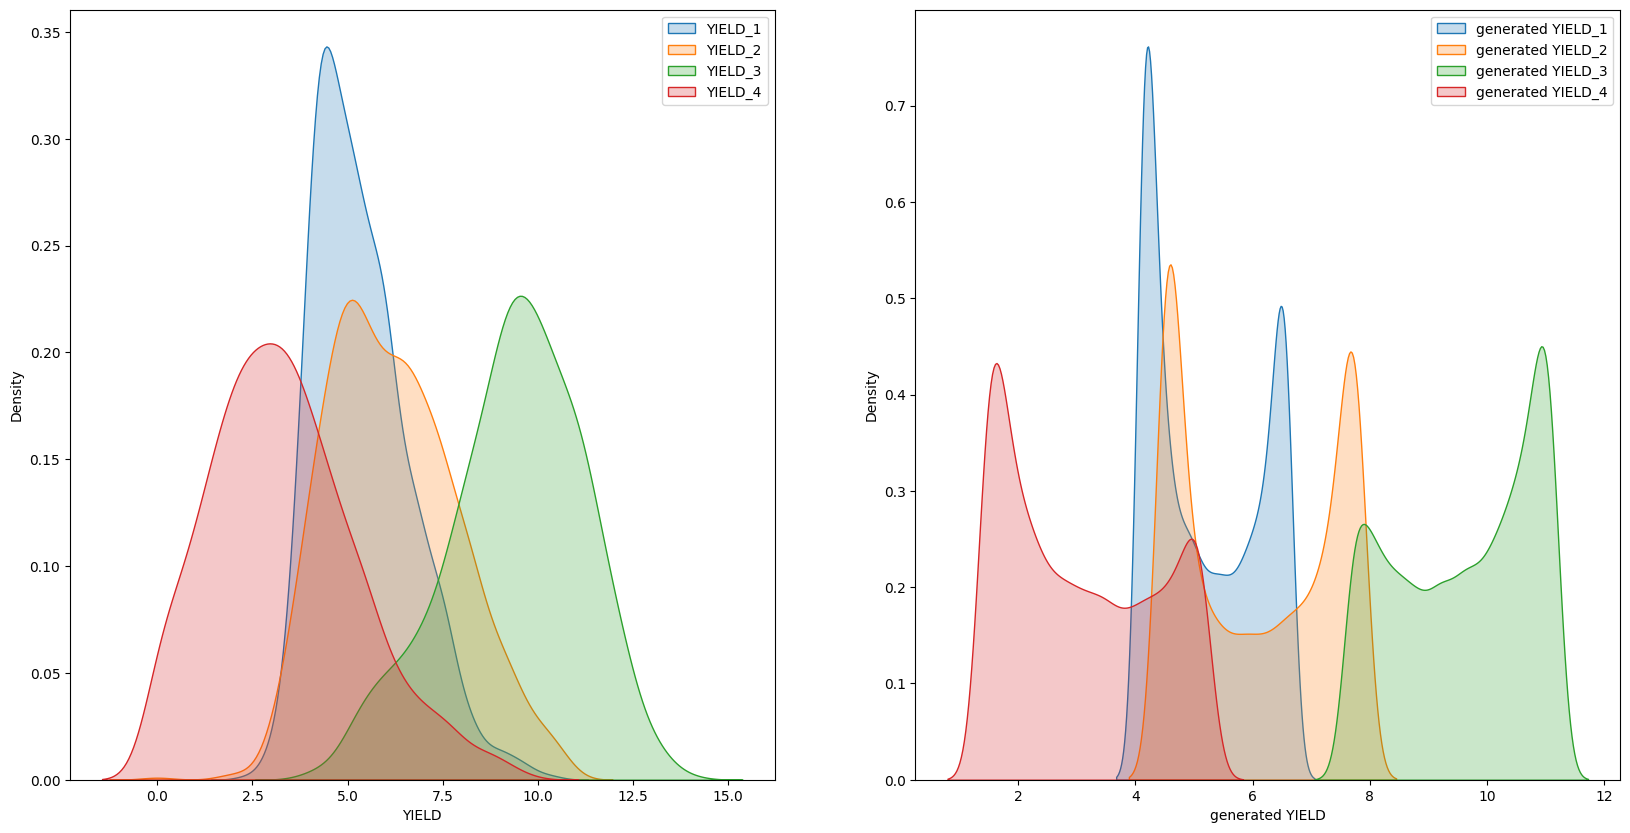

In [28]:
gan_model_23.oneshot(noise)